# Parallel Curve Fitting Notebook

#### This notebook is used to perform a parallelized non-linear least squares Lorentzian fit of the noisy Hyperspectral Optical Micrscope curves. The peak height, width, and position are then measured and saved for each data file from 0 - 15 minutes of UV-Ozone Oxidation and plotted to observe a trend in the evolution in these parameters over time. The functions generated from the allometric fitting of the peak fit parameters is then used to generate the synthetic data

# Load in Libraries

In [2]:
import hyperspy.api as hs
import hyperspy.signal_tools as hs_st
import hyperspy.axes as axes
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from hyperspy.signals import Signal1D
from tqdm import tqdm
import csv
from scipy.optimize import curve_fit
from lmfit.models import LorentzianModel
from sklearn.cluster import KMeans
import os
from lmfit.models import LorentzianModel
from joblib import Parallel, delayed

hs.set_log_level('INFO')

WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)


c:\Users\yuthm\Desktop\Python_Files\176Project\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)


# Define Functions for Loading/Processing Data and Fitting Curves

In [4]:
def loadFiles(title, size_arr, size_sel):
    """
    Function to load the files and crop them to the correct size.

    Args:
        title: The title of the file to be loaded
        size_arr: The array containing the size of the crop
        size_sel: The index of the size
    Returns:
        s0.data: 3D Hyperspy data array of size (300, 300, n_wavelengths)
    """
    #Image frame select and loading
    s0 = hs.load(title) # load the file
    s0.data = s0.data[::-1] # the file needs to be transposed to solve an issue with the array dimensions.

    s0.crop(1,size_arr[size_sel][0][0], size_arr[size_sel][0][1])
    s0.crop(2,size_arr[size_sel][1][0], size_arr[size_sel][1][1])

    # set titles and name variables.
    s0 = s0.as_signal1D(0)
    s0.axes_manager[0].name = "width"
    s0.axes_manager[1].name = "height"
    s0.axes_manager[2].name = "wavelength"
    s0.axes_manager[0].units = "pix"
    s0.axes_manager[1].units = "pix"
    s0.axes_manager[2].units = "nm"
    s0.axes_manager[2].offset = 200
    s0.axes_manager[2].scale = 4

    return s0.data

def subtract_background(data):
    """
    Subtract the background signal from the DRS data. Use the first 20 and last 20
    points of the spectrum to calculate the background signal.

    Args:
        data: The data array to be processed
    Returns:
        data: Background subtracted data array of the same length
    """
    x = np.arange(len(data))
    background_indices = np.concatenate((np.arange(20), np.arange(-20, 0)))  # Indices for the background points
    background_x = x[background_indices]
    background_y = data[background_indices]
    background_params = np.polyfit(background_x, background_y, 1)  # Fit a line
    background = np.polyval(background_params, x)
    return data - background

def fit_lorentzian_for_one_peak(data):
    """
    Function to fit a Lorentzian curve to the data.

    Args:
        data: The data array to be fitted to a lorentzian curve
    Returns:
        out: The fitted curve
    """
    data = subtract_background(data)
    x = np.arange(len(data))

    lorentz = LorentzianModel(prefix='l1_')
    pars = lorentz.guess(data, x=x)

    # Optional parameters can be uncommented to focus the fit around certain values

    # pars['l1_center'].set(value=50)
    # pars['l1_center'].set(min=10)
    # pars['l1_center'].set(max=90)
    # pars['l1_sigma'].set(value=0.1)
    # pars['l1_sigma'].set(max=15)
    # pars['l1_amplitude'].set(value=10)

    out = lorentz.fit(data, pars, x=x)
    return out

def manageData(data):
    """
    Function to output the peak fit parameters from the data in a readable way.

    Args:
        data: The data array to be processed
    Returns:
        params['l1_height'], params['l1_center'], params['l1_sigma']: The peak fit parameters
    """
    result = fit_lorentzian_for_one_peak(data)
    params = result.params.valuesdict()
    return (params['l1_height'], params['l1_center'], params['l1_sigma'])

def removeIssuePoint(data):
    """
    Function to remove miscalculation error from HOM.

    Args:
        data: The data array to be processed
    Returns:
        data: The data array after correcting the miscalculation
    """
    for x in range(len(data)):
        for y in range(len(data[0])):
            curMax = np.max(data[x][y])
            for z in range(len(data[0][0])):
                if data[x][y][z] == curMax:
                    data[x][y][z] = data[x][y][z-1] # Replace the miscalculation with the previous value
                    break
    return data

# Load in Fully Processed Data and Visualize Curve Fit

In [5]:
# Global variables to find triangle of interest from full image
size_sel = 1
size_arr = [[[345 ,350], [810, 815]], [[216, 516], [675, 975]], [[222, 495], [672, 972]]]

# Add names of files to list and load them into a list
file_list = []
for item in os.listdir('Time Series Oxidation Files'):
    if item.endswith('.tif'):
        file_list.append(item)

data_list = []
for item in file_list:
    data_list.append(loadFiles('Time Series Oxidation Files/'+item, size_arr, size_sel))

for file in tqdm(data_list):
    file = removeIssuePoint(file)

WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
WARNING | Hyperspy | Numba is not installed, falling back to non-accelerated implementation. (hyperspy.decorators:256)
INFO | Hyperspy | <Signal1D, title: , dimensions: (300, 300|151)> data is replaced by its optimized copy, see optimize parameter of ``Basesignal.transpose`` for more information. (hyperspy.signal:4119)
INFO | Hyperspy | <Signal1D, title: , dimensions: (300, 300|151)> data is replaced by its optimized copy, see optimize parameter of ``Basesignal.transpose`` for more information. (hyperspy.signal:4119)
ERROR | Hyperspy | If this file format is supported, please report this error to the RosettaSciIO developers at https://github.com/hyperspy/rosettasciio/issues (hyperspy.io:600)


KeyboardInterrupt: 

{'l1_amplitude': np.float64(16.42671257950961), 'l1_center': np.float64(71.52548879956277), 'l1_sigma': np.float64(10.613093950607631), 'l1_fwhm': np.float64(21.226187901215262), 'l1_height': np.float64(0.4926730379328341)}


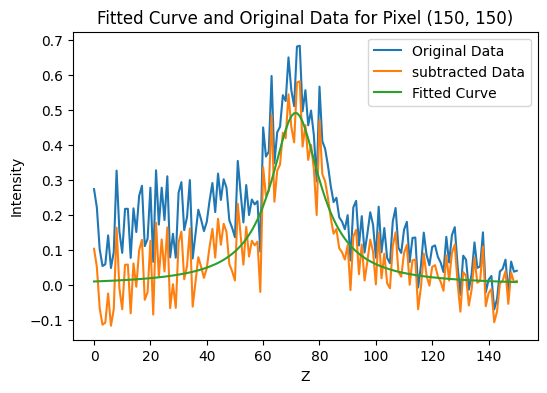

In [29]:
# Use only one pixel to test the code is right or not, by checking the fitted result
#####################################################################################################
#####################################################################################################

# Choose a pixel (e.g., pixel at position (x, y))
chosen_pixel = (150,150)
chosen_pixel_data = data_list[0][chosen_pixel[0], chosen_pixel[1], :]

# Subtract background from chosen pixel data
chosen_pixel_data_subtracted = subtract_background(chosen_pixel_data)

# Fit Lorentzian to the chosen pixel data
result = fit_lorentzian_for_one_peak(chosen_pixel_data)
params = result.params.valuesdict()
print(params)

# Plot original and fitted curve for the chosen pixel
plt.figure(figsize=(6, 4))
plt.plot(chosen_pixel_data, label='Original Data')
plt.plot(chosen_pixel_data_subtracted, label='subtracted Data')
plt.plot(result.best_fit, label='Fitted Curve', linestyle='-')
plt.title('Fitted Curve and Original Data for Pixel {}'.format(chosen_pixel))
plt.xlabel('Z')
plt.ylabel('Intensity')
plt.legend()
plt.show()

In [6]:
# Reshape all data into proper format for parallel curve fitting
for i in range(len(data_list)):
    height, width, signal_dimension = data_list[i].shape
    data_list[i] = data_list[i].reshape(height * width, signal_dimension)

# Perform Parallelized Curve Fitting on Full Dataset

In [7]:
def saveData(res, id):
    """
    Function to save the peak fit parameters from the data to .csv files

    Args:
        res: The peak fit parameters to be saved
        id: The oxidation time of the file to be saved
    Returns:
        True: If the files are saved successfully
    """
    amplitude_map = np.array([])
    center_map = np.array([])
    sigma_map = np.array([])
    results = np.array(res)

    for i in tqdm(range(len(results))):
        amplitude_map = np.append(amplitude_map, results[i][0])
        center_map = np.append(center_map, (results[i][1] + 550))
        sigma_map = np.append(sigma_map, results[i][2])

    # Create folder titled 'Peak Parameter CSV Files' if it does not already exist
    try:
        np.savetxt(f'Peak Parameter CSV Files/{id}minAmp.csv', amplitude_map.reshape(300,300), delimiter=',')
        np.savetxt(f'Peak Parameter CSV Files/{id}minCenter.csv', center_map.reshape(300,300), delimiter=',')
        np.savetxt(f'Peak Parameter CSV Files/{id}minSigma.csv', sigma_map.reshape(300,300), delimiter=',')
    except:
        os.mkdir('Peak Parameter CSV Files')
        np.savetxt(f'Peak Parameter CSV Files/{id}minAmp.csv', amplitude_map.reshape(300,300), delimiter=',')
        np.savetxt(f'Peak Parameter CSV Files/{id}minCenter.csv', center_map.reshape(300,300), delimiter=',')
        np.savetxt(f'Peak Parameter CSV Files/{id}minSigma.csv', sigma_map.reshape(300,300), delimiter=',')
    return True

def fit_all_curves_parallel(data_list, n_jobs=-1):
    """
    Parallelized function to fit curves to the entire data set.

    Args:
        data_list: The array of data arrays to be processed
        n_jobs: The number of jobs to run in parallel
    Returns:
        results: The peak fit parameters from the data
    """
    results = Parallel(n_jobs=n_jobs)(
        delayed(manageData)(data)
        for data in tqdm(data_list, desc="Fitting Lorentzian curves")
    )
    return results

for i in range(len(data_list)):
    results = fit_all_curves_parallel(data_list[i], n_jobs=20)
    saveData(results, file_list[i][0:2])

100%|██████████| 90000/90000 [00:04<00:00, 21140.26it/s]


# Load in Saved .csv Files

In [18]:
def csv2num(csv):
    """
    Function to convert all entries in .csv file to floats

    Args:
        data_list: The array of data arrays to be processed
        n_jobs: The number of jobs to run in parallel
    Returns:
        results: The peak fit parameters from the data
    """
    flattenedVec = csv.flatten()
    result = np.array([])
    for i in (range(len(flattenedVec))):
        result = np.append(result, float(flattenedVec[i]))
    return result

def openFiles():
    """
    Function to open the .csv files and convert them to numpy arrays.

    Args:
        None
    Returns:
        amp_list: The array of amplitude data
        center_list: The array of center data
        width_list: The array of width data
    """
    amp_list = []
    center_list = []
    width_list = []

    folder_path = 'Peak Parameter CSV Files'
    full_path = os.path.join(os.getcwd(), folder_path)

    for file in tqdm(os.listdir(full_path)):
        file_path = os.path.join(full_path, file)
        if file.endswith('Amp.csv'):
            with open(file_path, 'r') as f:
                reader = csv.reader(f)
                data = list(reader)
                amp_data = np.array(data)
                amp = csv2num(amp_data).reshape(300,300)
                amp_list.append(amp)

        elif file.endswith('Center.csv'):
            with open(file_path, 'r') as f:
                reader = csv.reader(f)
                data = list(reader)
                center_data = np.array(data)
                center = csv2num(center_data).reshape(300,300)
                center_list.append(center)

        elif file.endswith('Sigma.csv'):
            with open(file_path, 'r') as f:
                reader = csv.reader(f)
                data = list(reader)
                sigma_data = np.array(data)
                sigma = csv2num(sigma_data).reshape(300,300)
                width_list.append(sigma)

    return amp_list, center_list, width_list

amplitudes, positions, widths = openFiles()

100%|██████████| 48/48 [00:45<00:00,  1.07it/s]


# Extract Parameter Evolution and Save to .csv

In [19]:
def parAvg(data, xROI=20, yROI=20):
    """
    Function to calculate the average peak fit parameters from the data
    using only a 20x20 region of pixels in the center of the triangle.

    Args:
        data: The data array to be processed
        xROI: The number of pixels to use in the x direction
        yROI: The number of pixels to use in the y direction
    Returns:
        pars: The average peak fit parameters within the ROI
    """
    pars = 0
    for x in range(xROI):
        for y in range(yROI):
            pars += data[140+x][140+y]
    return pars/(xROI*yROI)

def getAveragePars(data):
    """
    Function to take average of all peak fit parameters from the data
    for a given time step.

    Args:
        data: The data array containing the peak fit parameters
    Returns:
        averagePar: The average peak fit parameters from the data
    """
    averagePar = []
    for item in tqdm(data):
        averagePar.append(parAvg(item))
    return averagePar

avgAmp = getAveragePars(amplitudes)
avgPos = getAveragePars(positions)
avgWidth = getAveragePars(widths)

100%|██████████| 16/16 [00:00<00:00, 5334.57it/s]


In [20]:
# Save these parameters to their own .csv files
try:
    np.savetxt(f'Average Parameters/Amplitudes.csv', avgAmp, delimiter=',')
    np.savetxt(f'Average Parameters/Positions.csv', avgPos, delimiter=',')
    np.savetxt(f'Average Parameters/Widths.csv', avgWidth, delimiter=',')
except:
    os.mkdir('Average Parameters')
    np.savetxt(f'Average Parameters/Amplitudes.csv', avgAmp, delimiter=',')
    np.savetxt(f'Average Parameters/Positions.csv', avgPos, delimiter=',')
    np.savetxt(f'Average Parameters/Widths.csv', avgWidth, delimiter=',')

# Visualize and Fit Curves to Parameter Evolution

#### Use the functions generated by these peak fits in the synthetic data model.

In [21]:
avgAmp = np.genfromtxt('Average Parameters/Amplitudes.csv', delimiter=',')
avgPos = np.genfromtxt('Average Parameters/Positions.csv', delimiter=',')
avgWidth = np.genfromtxt('Average Parameters/Widths.csv', delimiter=',')

### Peak Height

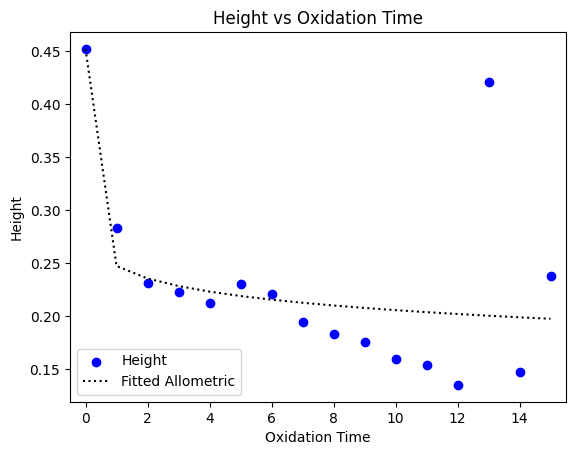

Fitted allometric function: y = 0.45232039349125364 + -0.20x^0.08


In [22]:
# Sample data
x = np.arange(0, 16)

# Define the allometric function
def allometric(x, a, b, c):
    return a + (b * x**c)

# Fit the allometric function to the data
params, covariance = curve_fit(allometric, x, avgAmp, maxfev=10000)

a, b, c = params

# Generate fitted values
y_fit = allometric(x, a, b, c)

# Scatter plot
plt.scatter(x, avgAmp, label='Height', color='blue')

# Plot the fitted allometric function
plt.plot(x, y_fit, label=f'Fitted Allometric', color='black', linestyle='dotted')

# Add legend and limits
plt.legend()
plt.title('Height vs Oxidation Time')
plt.ylabel('Height')
plt.xlabel('Oxidation Time')
plt.xlim((-0.5, 15.5))
plt.show()

# Print the parameters of the fitted function
print(f"Fitted allometric function: y = {a} + {b:.2f}x^{c:.2f}")

### Peak Width

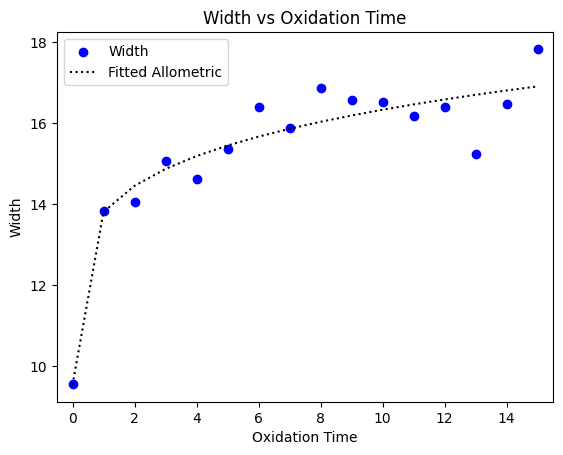

Fitted allometric function: y = 9.540053314175449 + 4.27x^0.20


In [23]:
# Sample data
x = np.arange(0, 16)

# Define the allometric function
def allometric(x, a, b, c):
    return a + (b * x**c)

# Fit the allometric function to the data
params, covariance = curve_fit(allometric, x, avgWidth, maxfev=10000)

a, b, c = params

# Generate fitted values
y_fit = allometric(x, a, b, c)

# Scatter plot
plt.scatter(x, avgWidth, label='Width', color='blue')

# Plot the fitted allometric function
plt.plot(x, y_fit, label=f'Fitted Allometric', color='black', linestyle='dotted')

# Add legend and limits
plt.legend()
plt.title('Width vs Oxidation Time')
plt.ylabel('Width')
plt.xlabel('Oxidation Time')
plt.xlim((-0.5, 15.5))
plt.show()

# Print the parameters of the fitted function
print(f"Fitted allometric function: y = {a} + {b:.2f}x^{c:.2f}")

### Peak Position

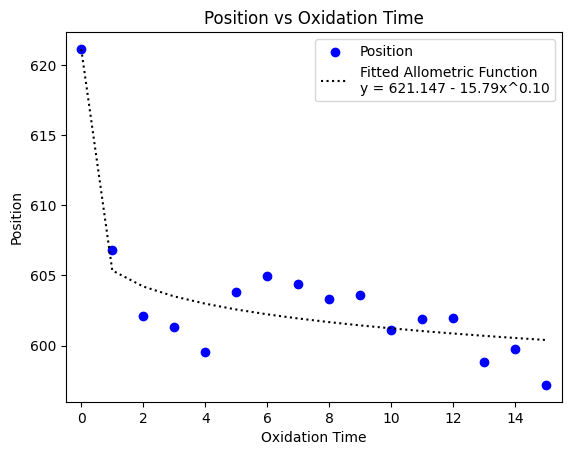

Fitted allometric function: y = 621.1472184236804 + -15.79x^0.10


In [35]:
# Sample data
x = np.arange(0, 16)

# Define the allometric function
def allometric(x, a, b, c):
    return c + (a * x**b)

# Fit the allometric function to the data
params, covariance = curve_fit(allometric, x, avgPos, maxfev=10000)

a, b, c = params

# Generate fitted values
y_fit = allometric(x, a, b, c)

# Scatter plot
plt.scatter(x, avgPos, label='Position', color='blue')

# Plot the fitted allometric function
plt.plot(x, y_fit, label=f'Fitted Allometric Function \ny = {np.round(c, 3)} - {np.abs(a):.2f}x^{b:.2f}', color='black', linestyle='dotted')

# Add legend and limits
plt.legend()
plt.title('Position vs Oxidation Time')
plt.ylabel('Position')
plt.xlabel('Oxidation Time')
plt.xlim((-0.5, 15.5))
plt.show()

# Print the parameters of the fitted function
print(f"Fitted allometric function: y = {c} + {a:.2f}x^{b:.2f}")